# Generative adversarial networks (GAN)

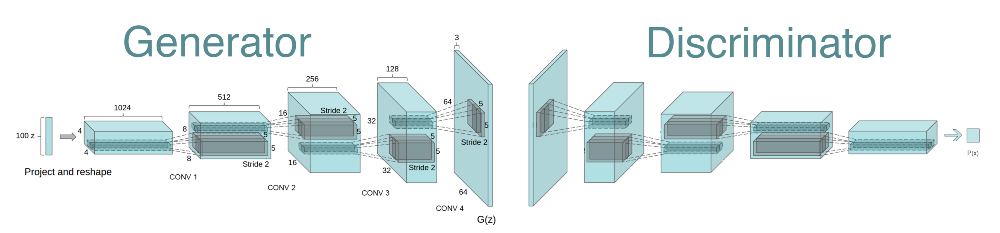

В данном ноутбуке построим Generative adversarial network (GAN) и обучим его на датасете лиц людей, познакомимся с архитектурой GAN, оценим качество генерации изображений.

In [1]:
import os
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as tt
import torch
import torch.nn as nn
from torch.optim import lr_scheduler 
import cv2
import imageio
from tqdm.notebook import tqdm
from torchvision.utils import save_image
from torchvision.utils import make_grid
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

## 1. Подготовка данных

В качестве обучающей выборки возьмем часть датасета [Flickr Faces](https://github.com/NVlabs/ffhq-dataset), который содержит изображения лиц людей в высоком разрешении (1024х1024). В нашем датасете 3143 изображения.

Загрузим наши изображения. Реализуем функцию, которая формирует DataLoader для изображений, при этом меняя их размер до нужного значения.

In [2]:
def get_dataloader(image_size, batch_size):
    train_ds = ImageFolder(DATA_DIR, transform=tt.Compose([
    tt.Resize(image_size),
    tt.CenterCrop(image_size),
    tt.ToTensor(),
    tt.Normalize(*stats)]))
    train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
    
    return train_dl

Создадим dataloader image_size и batch_size c помощью функции get_dataloader.

In [3]:
DATA_DIR = "./data/" # folder with the data
image_size = 64 # resize image size
batch_size = 64 # batch size
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5) # values for image normalization

train_dl = get_dataloader(image_size, batch_size)

Реализуем вспомогательные функции для работы с нашими данными:

In [4]:
# function to reverse normalization
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

# function to show images
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

# function which shows images in a batch
def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break
        
# function to save images
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

Посмотрим на изображения из датасета:

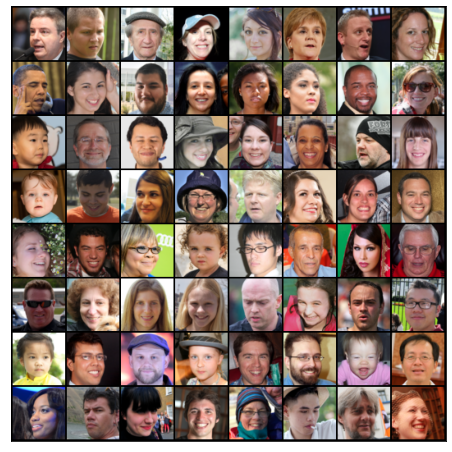

In [5]:
show_batch(train_dl)

## 2. Построение и обучение модели

Реализуем генератор и дискриминатор:
* Генератор принимает на вход тензор шумов размера `latent_size x 1 x 1` и генерирует изображение размера `3 x image_size x image_size`
* Дискриминатор принимает на вход изображение (тензор размера `3 x image_size x image_size`) и выдает вероятность того, что изображение настоящее (тензор размера 1)

Архитектура дискриминатора будет выглядеть следующим образом:
<br>
**Conv2d > BatchNorm2d > LeakyReLU**
<br>

In [6]:
class Discriminator(nn.Module):
    def __init__(self, in_ch, latent_size, f_maps, ngpu=1):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.latent_size = latent_size
        self.in_ch = in_ch
        self.f_maps = f_maps
        self.discriminate = nn.Sequential(
            
            # in_ch x 64 x 64 > f_maps[0] x 32 x 32
            nn.Conv2d(in_channels=in_ch, out_channels=f_maps[0], kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True), # 32
            
            # f_maps[1] x 32 x 32 > f_maps[2] x 16 x 16
            nn.Conv2d(in_channels=f_maps[0], out_channels=f_maps[1], kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(f_maps[1]),
            nn.LeakyReLU(0.2, inplace=True), # 16
            
            # f_maps[1] x 16 x 16 > f_maps[2] x 8 x 8
            nn.Conv2d(in_channels=f_maps[1], out_channels=f_maps[2], kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(f_maps[2]),
            nn.LeakyReLU(0.2, inplace=True), # 8
            
            # f_maps[2] x 8 x 8 > f_maps[3] x 4 x 4
            nn.Conv2d(in_channels=f_maps[2], out_channels=f_maps[3], kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(f_maps[3]),
            nn.LeakyReLU(0.2, inplace=True), # 4
            
            # f_maps[3] x 4 x 4 > 1 x 1 x 1
            nn.Conv2d(in_channels=f_maps[3], out_channels=1, kernel_size=4, stride=1, padding=0),
            
            nn.Sigmoid(),
            nn.Flatten(),
        
        )
        
    def forward(self, x):
        return self.discriminate(x)

Генератор будет же иметь следующую архитектуру:
<br>
**TransposeConv2d > BatchNorm2d > LeakyReLU** и **nn.Tanh** на выходном слое.

In [7]:
class Generator(nn.Module):
    def __init__(self, out_ch, latent_size, f_maps, ngpu=1):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.latent_size = latent_size
        self.out_ch = out_ch
        self.f_maps = f_maps
        
        self.generate = nn.Sequential(
            
            # latent_size x 1 x 1 > f_maps[0] x 4 x 4
            nn.ConvTranspose2d(in_channels=latent_size, out_channels=f_maps[0],
                               kernel_size=4, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(f_maps[0]),
            nn.LeakyReLU(0.2, inplace=True), # 4
            
            # f_maps[0] x 4 x 4 > f_maps[1] x 8 x 8
            nn.ConvTranspose2d(in_channels=f_maps[0], out_channels=f_maps[1],
                               kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(f_maps[1]),
            nn.LeakyReLU(0.2, inplace=True), # 8
            
            # f_maps[1] x 8 x 8 > f_maps[2] x 16 x 16
            nn.ConvTranspose2d(in_channels=f_maps[1], out_channels=f_maps[2],
                               kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(f_maps[2]),
            nn.LeakyReLU(0.2, inplace=True), # 16
            
            # f_maps[2] x 16 x 16 > f_maps[3] x 32 x 32
            nn.ConvTranspose2d(in_channels=f_maps[2], out_channels=f_maps[3],
                               kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(f_maps[3]),
            nn.LeakyReLU(0.2, inplace=True), # 32
            
            # f_maps[3] x 32 x 32 > out_ch x 64 x 64
            nn.ConvTranspose2d(in_channels=f_maps[3], out_channels=out_ch,
                               kernel_size=4, stride=2, padding=1, bias=False),
            
            nn.Tanh(),

        )
        
    def forward(self, x):
        return self.generate(x)

Посмотрим как работает наш генератор на рандомном шуме:

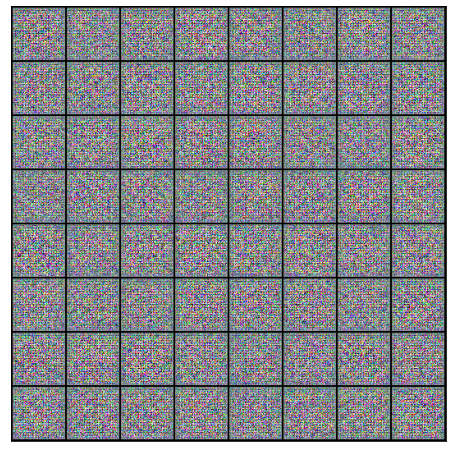

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # init a training device
#train_dl = DeviceDataLoader(train_dl, device) # create a training dataloader

latent_size = 128 # shape of a latent space
xb = torch.randn(batch_size, latent_size, 1, 1) # random noise of a batch_size x latent_size
generator = Generator(out_ch=3, latent_size=latent_size, f_maps=[512, 256, 128, 64]) # init a generator


fake_images = generator(xb) # forward-pass
show_images(fake_images) # show images

Перейдем теперь к обучению нашего GANа. Алгоритм обучения следующий:
1. Учим дискриминатор:
  * Берем реальные изображения и присваиваем им метку 1
  * Генерируем изображения генератором и присваиваем им метку 0
  * Обучаем классификатор на два класса

2. Учим генератор:
  * Генерируем изображения генератором и присваиваем им метку 0
  * Предсказываем дискриминаторором, реальное это изображение или нет




Также в обучении модели будем использовать функцию smooth labels. Она будет приводить лейблы к определенному диапазону. Например, для обучения дискриминатора будем использовать лейблы в определенном диапазоне, а не строго 1.

In [9]:
def smooth_labels(low, high, size, device):
    smoothed = np.random.uniform(low, high, size)
    
    return torch.FloatTensor(smoothed).to(device)

Напишем цикл обучения для генератора и дискриминатора:

In [10]:
def fit(model, criterion, optimizer, epochs, latent_shape, start_idx=1):
    # set models to a training mode
    model["discriminator"].train()
    model["generator"].train()
    torch.cuda.empty_cache() # clear GPU cache
    
    # losses & scores
    losses_g = [] # generator losses
    losses_d = [] # discriminator losses
    real_scores = [] # real scores
    fake_scores = [] # fake scores
    
    
    for epoch in range(epochs):
        loss_d_per_epoch = [] # discriminator losses
        loss_g_per_epoch = [] # generator losses
        real_score_per_epoch = [] # real scores per epoch
        fake_score_per_epoch = [] # fake scores per epoch
        
        for real_images, _ in tqdm(train_dl):
            # train discriminator
            real_images = real_images.to(device)
            cur_batch_size = real_images.size(0)
            optimizer["discriminator"].zero_grad() # Clear discriminator gradients

            # pass real images through discriminator
            real_preds = model["discriminator"](real_images) # discriminator forward-pass with real images as input
            real_targets = smooth_labels(low=0.7, high=1.2, 
                                         size=(cur_batch_size, real_preds.size(1)), device=device) # generate real targets
            real_loss = criterion(real_preds, real_targets) # calculate the discriminator loss
            cur_real_score = torch.mean(real_preds).item() # calculate the current real score
            
            # generate fake images
            latent = torch.randn(cur_batch_size, latent_size,
                                 latent_shape, latent_shape, device=device) # generate latents of
                                                                               # current batch size x latent_size
            fake_images = model["generator"](latent) # generator forward-pass

            # pass fake images through discriminator
            fake_preds = model["discriminator"](fake_images) # discriminator forward-pass with fake images as input
            fake_targets = torch.zeros(cur_batch_size, fake_preds.size(1), device=device) # generate fake targets
            fake_loss = criterion(fake_preds, fake_targets) # calculate the discriminator loss
            cur_fake_score = torch.mean(fake_preds).item() # calculate the current fake score

            # save scores
            real_score_per_epoch.append(cur_real_score)
            fake_score_per_epoch.append(cur_fake_score)

            # Update discriminator weights
            loss_d = real_loss + fake_loss # calculate the overall discriminator loss
            loss_d.backward() # discriminator backward-pass
            optimizer["discriminator"].step() # update discriminator weights
            loss_d_per_epoch.append(loss_d.item()) # save the loss value

            # train generator
            optimizer["generator"].zero_grad() # clear generator gradients
            
            # generate fake images
            latent = torch.randn(cur_batch_size, latent_size, latent_shape,
                                 latent_shape, device=device) # generate latents of# current batch_size x latent_size
            fake_images = model["generator"](latent) # generator forward-pass with latents
            
            # try to fool the discriminator
            preds = model["discriminator"](fake_images) # discriminator forward-pass with fake generated images
            targets = smooth_labels(low=0.7, high=1.2, size=(cur_batch_size, preds.size(1)), device=device)
            loss_g = criterion(preds, targets) # calculate the generator loss
            
            # Update generator weights
            loss_g.backward() # generator backward-pass
            optimizer["generator"].step() # update generator weights
            loss_g_per_epoch.append(loss_g.item()) # save the loss value
        
        # save losses & scores per epoch
        losses_g.append(np.mean(loss_g_per_epoch))
        losses_d.append(np.mean(loss_d_per_epoch))
        real_scores.append(np.mean(real_score_per_epoch))
        fake_scores.append(np.mean(fake_score_per_epoch))
        
        # log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch + 1, epochs, 
            losses_g[-1], losses_d[-1], real_scores[-1], fake_scores[-1]))
    
        save_samples(epoch + start_idx, fixed_latent, show=False) # save generated images to evaluate perfomance
        
    
    return losses_g, losses_d, real_scores, fake_scores

Создадим папку для сохранения сгенерированных изображений:

In [11]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

Определим параметры обучения, модели дискриминатора и генератора, а также лосс и оптимизаторы. В качестве функции потерь берем бинарную кросс-энтропию (nn.BCE).

In [12]:
# set & update training parameters
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # init a training device

# learning rate for optimizers
lr_d = 0.0002 # discriminator learning rate
lr_g = 0.0002 # generator learning rate
epochs = 150 # number of epochs
latent_size = 128 # size of the latent space
latent_shape = 1

fixed_latent = torch.randn(batch_size, latent_size, latent_shape, latent_shape,
                           device=device) # Create batch of latent vectorsto visualizethe progression of the generator

# create models
discriminator = Discriminator(in_ch=3, latent_size=latent_size, f_maps=[64, 128, 256, 512]).to(device)
generator = Generator(out_ch=3, latent_size=latent_size, f_maps=[512, 256, 128, 64]).to(device)

# create losses
criterion = nn.BCELoss()

# create optimizers
optim_dis = torch.optim.Adam(discriminator.parameters(), lr=lr_d, betas=(0.5, 0.9)) # betas=(0.5, 0.999)
optim_gen = torch.optim.Adam(generator.parameters(), lr=lr_g, betas=(0.5, 0.9))

# wrap models
model = {
    "discriminator": discriminator,
    "generator": generator
}

# wrap optimizers
optimizer = {
    "discriminator": optim_dis,
    "generator": optim_gen
}

Обучим GAN с заданными параметрами:

In [13]:
history = fit(model, criterion, optimizer, epochs, latent_shape)

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [1/150], loss_g: 7.4053, loss_d: 0.4209, real_score: 0.8812, fake_score: 0.0921
Saving generated-images-0001.png


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [2/150], loss_g: 6.0972, loss_d: 0.5687, real_score: 0.8295, fake_score: 0.1376
Saving generated-images-0002.png


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [3/150], loss_g: 4.3267, loss_d: 0.7434, real_score: 0.7556, fake_score: 0.1919
Saving generated-images-0003.png


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [4/150], loss_g: 3.2868, loss_d: 0.8312, real_score: 0.7246, fake_score: 0.2443
Saving generated-images-0004.png


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [5/150], loss_g: 3.0291, loss_d: 0.9705, real_score: 0.6705, fake_score: 0.2754
Saving generated-images-0005.png


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [6/150], loss_g: 2.9719, loss_d: 0.9209, real_score: 0.6838, fake_score: 0.2712
Saving generated-images-0006.png


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [7/150], loss_g: 3.3960, loss_d: 0.8656, real_score: 0.7089, fake_score: 0.2482
Saving generated-images-0007.png


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [8/150], loss_g: 3.1994, loss_d: 0.8793, real_score: 0.6985, fake_score: 0.2549
Saving generated-images-0008.png


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [9/150], loss_g: 3.3238, loss_d: 0.7993, real_score: 0.7252, fake_score: 0.2309
Saving generated-images-0009.png


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [10/150], loss_g: 3.2876, loss_d: 0.7780, real_score: 0.7351, fake_score: 0.2148
Saving generated-images-0010.png


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [11/150], loss_g: 3.4229, loss_d: 0.7437, real_score: 0.7429, fake_score: 0.2072
Saving generated-images-0011.png


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [12/150], loss_g: 3.2583, loss_d: 0.7583, real_score: 0.7349, fake_score: 0.2098
Saving generated-images-0012.png


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [13/150], loss_g: 3.1244, loss_d: 0.7265, real_score: 0.7515, fake_score: 0.2086
Saving generated-images-0013.png


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [14/150], loss_g: 3.0551, loss_d: 0.7552, real_score: 0.7349, fake_score: 0.2076
Saving generated-images-0014.png


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [15/150], loss_g: 3.0128, loss_d: 0.7482, real_score: 0.7300, fake_score: 0.2178
Saving generated-images-0015.png


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [16/150], loss_g: 3.2218, loss_d: 0.7639, real_score: 0.7441, fake_score: 0.2265
Saving generated-images-0016.png


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [17/150], loss_g: 3.0644, loss_d: 0.7604, real_score: 0.7262, fake_score: 0.2161
Saving generated-images-0017.png


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [18/150], loss_g: 3.1097, loss_d: 0.7619, real_score: 0.7343, fake_score: 0.2187
Saving generated-images-0018.png


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [19/150], loss_g: 3.0236, loss_d: 0.7725, real_score: 0.7309, fake_score: 0.2246
Saving generated-images-0019.png


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [20/150], loss_g: 3.1083, loss_d: 0.7386, real_score: 0.7326, fake_score: 0.2138
Saving generated-images-0020.png


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [21/150], loss_g: 3.1991, loss_d: 0.7507, real_score: 0.7400, fake_score: 0.2057
Saving generated-images-0021.png


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [22/150], loss_g: 3.1566, loss_d: 0.7070, real_score: 0.7487, fake_score: 0.2065
Saving generated-images-0022.png


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [23/150], loss_g: 3.2193, loss_d: 0.6740, real_score: 0.7625, fake_score: 0.1995
Saving generated-images-0023.png


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [24/150], loss_g: 3.2034, loss_d: 0.6595, real_score: 0.7595, fake_score: 0.1784
Saving generated-images-0024.png


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [25/150], loss_g: 3.3632, loss_d: 0.6061, real_score: 0.7870, fake_score: 0.1713
Saving generated-images-0025.png


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [26/150], loss_g: 3.4481, loss_d: 0.6365, real_score: 0.7749, fake_score: 0.1591
Saving generated-images-0026.png


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [27/150], loss_g: 3.3995, loss_d: 0.6011, real_score: 0.7904, fake_score: 0.1668
Saving generated-images-0027.png


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [28/150], loss_g: 3.5972, loss_d: 0.5806, real_score: 0.7932, fake_score: 0.1500
Saving generated-images-0028.png


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [29/150], loss_g: 3.4247, loss_d: 0.5258, real_score: 0.8115, fake_score: 0.1396
Saving generated-images-0029.png


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [30/150], loss_g: 3.7600, loss_d: 0.5280, real_score: 0.8171, fake_score: 0.1338
Saving generated-images-0030.png


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [31/150], loss_g: 3.6129, loss_d: 0.5506, real_score: 0.7993, fake_score: 0.1410
Saving generated-images-0031.png


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [32/150], loss_g: 3.7392, loss_d: 0.5525, real_score: 0.8164, fake_score: 0.1410
Saving generated-images-0032.png


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [33/150], loss_g: 3.7255, loss_d: 0.5413, real_score: 0.8140, fake_score: 0.1361
Saving generated-images-0033.png


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [34/150], loss_g: 3.7395, loss_d: 0.4942, real_score: 0.8255, fake_score: 0.1098
Saving generated-images-0034.png


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [35/150], loss_g: 3.7194, loss_d: 0.5538, real_score: 0.8179, fake_score: 0.1292
Saving generated-images-0035.png


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [36/150], loss_g: 3.8442, loss_d: 0.5640, real_score: 0.8175, fake_score: 0.1401
Saving generated-images-0036.png


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [37/150], loss_g: 3.8877, loss_d: 0.5213, real_score: 0.8216, fake_score: 0.1231
Saving generated-images-0037.png


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [38/150], loss_g: 3.9652, loss_d: 0.4943, real_score: 0.8277, fake_score: 0.1216
Saving generated-images-0038.png


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [39/150], loss_g: 3.8338, loss_d: 0.5360, real_score: 0.8219, fake_score: 0.1282
Saving generated-images-0039.png


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [40/150], loss_g: 4.0232, loss_d: 0.5429, real_score: 0.8144, fake_score: 0.1229
Saving generated-images-0040.png


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [41/150], loss_g: 4.1383, loss_d: 0.4831, real_score: 0.8452, fake_score: 0.1255
Saving generated-images-0041.png


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [42/150], loss_g: 3.9159, loss_d: 0.5229, real_score: 0.8259, fake_score: 0.1251
Saving generated-images-0042.png


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [43/150], loss_g: 4.1856, loss_d: 0.4672, real_score: 0.8392, fake_score: 0.1145
Saving generated-images-0043.png


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [44/150], loss_g: 4.0592, loss_d: 0.5052, real_score: 0.8327, fake_score: 0.1139
Saving generated-images-0044.png


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [45/150], loss_g: 4.0111, loss_d: 0.4730, real_score: 0.8427, fake_score: 0.1089
Saving generated-images-0045.png


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [46/150], loss_g: 4.0181, loss_d: 0.4959, real_score: 0.8347, fake_score: 0.1151
Saving generated-images-0046.png


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [47/150], loss_g: 3.9716, loss_d: 0.4893, real_score: 0.8345, fake_score: 0.1122
Saving generated-images-0047.png


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [48/150], loss_g: 4.0867, loss_d: 0.4814, real_score: 0.8431, fake_score: 0.1040
Saving generated-images-0048.png


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [49/150], loss_g: 3.9810, loss_d: 0.5221, real_score: 0.8346, fake_score: 0.1118
Saving generated-images-0049.png


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [50/150], loss_g: 3.9814, loss_d: 0.4867, real_score: 0.8376, fake_score: 0.1100
Saving generated-images-0050.png


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [51/150], loss_g: 3.9895, loss_d: 0.4834, real_score: 0.8399, fake_score: 0.1157
Saving generated-images-0051.png


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [52/150], loss_g: 4.0858, loss_d: 0.4785, real_score: 0.8424, fake_score: 0.1096
Saving generated-images-0052.png


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [53/150], loss_g: 4.1267, loss_d: 0.4750, real_score: 0.8449, fake_score: 0.1070
Saving generated-images-0053.png


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [54/150], loss_g: 3.9963, loss_d: 0.4910, real_score: 0.8347, fake_score: 0.1083
Saving generated-images-0054.png


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [55/150], loss_g: 4.0165, loss_d: 0.5121, real_score: 0.8372, fake_score: 0.1204
Saving generated-images-0055.png


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [56/150], loss_g: 3.8884, loss_d: 0.4818, real_score: 0.8394, fake_score: 0.1052
Saving generated-images-0056.png


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [57/150], loss_g: 4.1098, loss_d: 0.4464, real_score: 0.8515, fake_score: 0.1075
Saving generated-images-0057.png


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [58/150], loss_g: 4.1334, loss_d: 0.4756, real_score: 0.8459, fake_score: 0.1033
Saving generated-images-0058.png


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [59/150], loss_g: 4.1796, loss_d: 0.4705, real_score: 0.8484, fake_score: 0.1047
Saving generated-images-0059.png


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [60/150], loss_g: 4.0468, loss_d: 0.4280, real_score: 0.8583, fake_score: 0.0888
Saving generated-images-0060.png


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [61/150], loss_g: 4.3310, loss_d: 0.4807, real_score: 0.8448, fake_score: 0.1099
Saving generated-images-0061.png


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [62/150], loss_g: 4.0767, loss_d: 0.4681, real_score: 0.8496, fake_score: 0.1015
Saving generated-images-0062.png


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [63/150], loss_g: 4.1263, loss_d: 0.4763, real_score: 0.8489, fake_score: 0.1059
Saving generated-images-0063.png


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [64/150], loss_g: 4.1045, loss_d: 0.4620, real_score: 0.8524, fake_score: 0.0949
Saving generated-images-0064.png


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [65/150], loss_g: 4.0993, loss_d: 0.4350, real_score: 0.8564, fake_score: 0.0952
Saving generated-images-0065.png


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [66/150], loss_g: 4.0796, loss_d: 0.4442, real_score: 0.8545, fake_score: 0.0958
Saving generated-images-0066.png


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [67/150], loss_g: 4.2697, loss_d: 0.4476, real_score: 0.8559, fake_score: 0.1009
Saving generated-images-0067.png


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [68/150], loss_g: 4.2329, loss_d: 0.4467, real_score: 0.8566, fake_score: 0.0929
Saving generated-images-0068.png


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [69/150], loss_g: 4.2614, loss_d: 0.4611, real_score: 0.8520, fake_score: 0.0982
Saving generated-images-0069.png


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [70/150], loss_g: 4.2884, loss_d: 0.4282, real_score: 0.8566, fake_score: 0.0877
Saving generated-images-0070.png


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [71/150], loss_g: 4.0519, loss_d: 0.4672, real_score: 0.8669, fake_score: 0.0997
Saving generated-images-0071.png


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [72/150], loss_g: 4.2732, loss_d: 0.4485, real_score: 0.8595, fake_score: 0.0878
Saving generated-images-0072.png


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [73/150], loss_g: 4.0827, loss_d: 0.4673, real_score: 0.8507, fake_score: 0.1000
Saving generated-images-0073.png


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [74/150], loss_g: 4.1754, loss_d: 0.4077, real_score: 0.8657, fake_score: 0.0842
Saving generated-images-0074.png


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [75/150], loss_g: 4.3917, loss_d: 0.4759, real_score: 0.8599, fake_score: 0.0936
Saving generated-images-0075.png


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [76/150], loss_g: 4.3722, loss_d: 0.4065, real_score: 0.8768, fake_score: 0.0777
Saving generated-images-0076.png


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [77/150], loss_g: 4.1333, loss_d: 0.4483, real_score: 0.8626, fake_score: 0.0884
Saving generated-images-0077.png


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [78/150], loss_g: 4.3047, loss_d: 0.4156, real_score: 0.8719, fake_score: 0.0827
Saving generated-images-0078.png


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [79/150], loss_g: 4.2206, loss_d: 0.4372, real_score: 0.8578, fake_score: 0.0820
Saving generated-images-0079.png


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [80/150], loss_g: 4.2564, loss_d: 0.4852, real_score: 0.8538, fake_score: 0.1011
Saving generated-images-0080.png


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [81/150], loss_g: 4.4410, loss_d: 0.4175, real_score: 0.8671, fake_score: 0.0716
Saving generated-images-0081.png


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [82/150], loss_g: 4.2045, loss_d: 0.4082, real_score: 0.8759, fake_score: 0.0787
Saving generated-images-0082.png


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [83/150], loss_g: 4.2869, loss_d: 0.4634, real_score: 0.8542, fake_score: 0.0913
Saving generated-images-0083.png


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [84/150], loss_g: 4.2809, loss_d: 0.4252, real_score: 0.8681, fake_score: 0.0837
Saving generated-images-0084.png


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [85/150], loss_g: 4.3123, loss_d: 0.4354, real_score: 0.8690, fake_score: 0.0807
Saving generated-images-0085.png


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [86/150], loss_g: 4.1594, loss_d: 0.4440, real_score: 0.8629, fake_score: 0.0807
Saving generated-images-0086.png


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [87/150], loss_g: 4.3703, loss_d: 0.4380, real_score: 0.8649, fake_score: 0.0871
Saving generated-images-0087.png


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [88/150], loss_g: 4.2759, loss_d: 0.3892, real_score: 0.8733, fake_score: 0.0796
Saving generated-images-0088.png


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [89/150], loss_g: 4.3713, loss_d: 0.4206, real_score: 0.8714, fake_score: 0.0821
Saving generated-images-0089.png


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [90/150], loss_g: 4.3988, loss_d: 0.3826, real_score: 0.8774, fake_score: 0.0661
Saving generated-images-0090.png


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [91/150], loss_g: 4.3570, loss_d: 0.4316, real_score: 0.8707, fake_score: 0.0827
Saving generated-images-0091.png


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [92/150], loss_g: 4.3748, loss_d: 0.4008, real_score: 0.8818, fake_score: 0.0717
Saving generated-images-0092.png


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [93/150], loss_g: 4.2926, loss_d: 0.4456, real_score: 0.8656, fake_score: 0.0803
Saving generated-images-0093.png


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [94/150], loss_g: 4.4693, loss_d: 0.3681, real_score: 0.8875, fake_score: 0.0665
Saving generated-images-0094.png


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [95/150], loss_g: 4.3317, loss_d: 0.4362, real_score: 0.8726, fake_score: 0.0743
Saving generated-images-0095.png


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [96/150], loss_g: 4.4773, loss_d: 0.4183, real_score: 0.8777, fake_score: 0.0786
Saving generated-images-0096.png


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [97/150], loss_g: 4.4483, loss_d: 0.4033, real_score: 0.8774, fake_score: 0.0745
Saving generated-images-0097.png


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [98/150], loss_g: 4.3603, loss_d: 0.4136, real_score: 0.8760, fake_score: 0.0681
Saving generated-images-0098.png


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [99/150], loss_g: 4.3755, loss_d: 0.4104, real_score: 0.8783, fake_score: 0.0706
Saving generated-images-0099.png


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [100/150], loss_g: 4.2621, loss_d: 0.4299, real_score: 0.8726, fake_score: 0.0793
Saving generated-images-0100.png


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [101/150], loss_g: 4.3761, loss_d: 0.4089, real_score: 0.8772, fake_score: 0.0762
Saving generated-images-0101.png


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [102/150], loss_g: 4.4638, loss_d: 0.3967, real_score: 0.8825, fake_score: 0.0626
Saving generated-images-0102.png


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [103/150], loss_g: 4.3168, loss_d: 0.4123, real_score: 0.8765, fake_score: 0.0749
Saving generated-images-0103.png


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [104/150], loss_g: 4.3595, loss_d: 0.3714, real_score: 0.8861, fake_score: 0.0616
Saving generated-images-0104.png


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [105/150], loss_g: 4.1998, loss_d: 0.4107, real_score: 0.8743, fake_score: 0.0762
Saving generated-images-0105.png


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [106/150], loss_g: 4.4028, loss_d: 0.4070, real_score: 0.8785, fake_score: 0.0710
Saving generated-images-0106.png


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [107/150], loss_g: 4.4163, loss_d: 0.3921, real_score: 0.8825, fake_score: 0.0746
Saving generated-images-0107.png


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [108/150], loss_g: 4.4850, loss_d: 0.3452, real_score: 0.8926, fake_score: 0.0608
Saving generated-images-0108.png


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [109/150], loss_g: 4.4664, loss_d: 0.4137, real_score: 0.8756, fake_score: 0.0696
Saving generated-images-0109.png


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [110/150], loss_g: 4.4621, loss_d: 0.3672, real_score: 0.8821, fake_score: 0.0646
Saving generated-images-0110.png


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [111/150], loss_g: 4.5380, loss_d: 0.3991, real_score: 0.8838, fake_score: 0.0714
Saving generated-images-0111.png


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [112/150], loss_g: 4.2162, loss_d: 0.3876, real_score: 0.8819, fake_score: 0.0706
Saving generated-images-0112.png


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [113/150], loss_g: 4.4792, loss_d: 0.3730, real_score: 0.8925, fake_score: 0.0637
Saving generated-images-0113.png


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [114/150], loss_g: 4.3792, loss_d: 0.4546, real_score: 0.8726, fake_score: 0.0746
Saving generated-images-0114.png


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [115/150], loss_g: 4.4244, loss_d: 0.3704, real_score: 0.8867, fake_score: 0.0597
Saving generated-images-0115.png


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [116/150], loss_g: 4.3238, loss_d: 0.3993, real_score: 0.8790, fake_score: 0.0731
Saving generated-images-0116.png


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [117/150], loss_g: 4.3711, loss_d: 0.3780, real_score: 0.8893, fake_score: 0.0571
Saving generated-images-0117.png


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [118/150], loss_g: 4.3897, loss_d: 0.3616, real_score: 0.8947, fake_score: 0.0603
Saving generated-images-0118.png


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [119/150], loss_g: 4.3986, loss_d: 0.4056, real_score: 0.8825, fake_score: 0.0665
Saving generated-images-0119.png


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [120/150], loss_g: 4.4426, loss_d: 0.3678, real_score: 0.8909, fake_score: 0.0573
Saving generated-images-0120.png


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [121/150], loss_g: 4.4626, loss_d: 0.3937, real_score: 0.8848, fake_score: 0.0696
Saving generated-images-0121.png


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [122/150], loss_g: 4.3599, loss_d: 0.3512, real_score: 0.8941, fake_score: 0.0541
Saving generated-images-0122.png


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [123/150], loss_g: 4.4599, loss_d: 0.4045, real_score: 0.8802, fake_score: 0.0654
Saving generated-images-0123.png


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [124/150], loss_g: 4.5287, loss_d: 0.3612, real_score: 0.8876, fake_score: 0.0598
Saving generated-images-0124.png


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [125/150], loss_g: 4.3994, loss_d: 0.3903, real_score: 0.8845, fake_score: 0.0742
Saving generated-images-0125.png


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [126/150], loss_g: 4.4285, loss_d: 0.3468, real_score: 0.8958, fake_score: 0.0565
Saving generated-images-0126.png


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [127/150], loss_g: 4.4464, loss_d: 0.3617, real_score: 0.8914, fake_score: 0.0578
Saving generated-images-0127.png


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [128/150], loss_g: 4.5012, loss_d: 0.3853, real_score: 0.8923, fake_score: 0.0606
Saving generated-images-0128.png


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [129/150], loss_g: 4.4043, loss_d: 0.3751, real_score: 0.8900, fake_score: 0.0614
Saving generated-images-0129.png


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [130/150], loss_g: 4.3623, loss_d: 0.3470, real_score: 0.9007, fake_score: 0.0580
Saving generated-images-0130.png


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [131/150], loss_g: 4.5057, loss_d: 0.3914, real_score: 0.8890, fake_score: 0.0628
Saving generated-images-0131.png


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [132/150], loss_g: 4.4104, loss_d: 0.3687, real_score: 0.8953, fake_score: 0.0560
Saving generated-images-0132.png


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [133/150], loss_g: 4.6222, loss_d: 0.3441, real_score: 0.9009, fake_score: 0.0481
Saving generated-images-0133.png


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [134/150], loss_g: 4.4061, loss_d: 0.3695, real_score: 0.8945, fake_score: 0.0552
Saving generated-images-0134.png


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [135/150], loss_g: 4.3477, loss_d: 0.3794, real_score: 0.8858, fake_score: 0.0634
Saving generated-images-0135.png


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [136/150], loss_g: 4.5919, loss_d: 0.3926, real_score: 0.8937, fake_score: 0.0630
Saving generated-images-0136.png


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [137/150], loss_g: 4.5262, loss_d: 0.3974, real_score: 0.8792, fake_score: 0.0577
Saving generated-images-0137.png


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [138/150], loss_g: 4.4746, loss_d: 0.3871, real_score: 0.8932, fake_score: 0.0688
Saving generated-images-0138.png


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [139/150], loss_g: 4.6163, loss_d: 0.3223, real_score: 0.9105, fake_score: 0.0476
Saving generated-images-0139.png


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [140/150], loss_g: 4.5020, loss_d: 0.3930, real_score: 0.8847, fake_score: 0.0586
Saving generated-images-0140.png


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [141/150], loss_g: 4.5609, loss_d: 0.3663, real_score: 0.8924, fake_score: 0.0558
Saving generated-images-0141.png


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [142/150], loss_g: 4.5915, loss_d: 0.3801, real_score: 0.8886, fake_score: 0.0544
Saving generated-images-0142.png


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [143/150], loss_g: 4.4477, loss_d: 0.3609, real_score: 0.8958, fake_score: 0.0584
Saving generated-images-0143.png


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [144/150], loss_g: 4.5033, loss_d: 0.3812, real_score: 0.8893, fake_score: 0.0615
Saving generated-images-0144.png


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [145/150], loss_g: 4.5369, loss_d: 0.3405, real_score: 0.8980, fake_score: 0.0458
Saving generated-images-0145.png


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [146/150], loss_g: 4.4547, loss_d: 0.3732, real_score: 0.8913, fake_score: 0.0640
Saving generated-images-0146.png


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [147/150], loss_g: 4.4879, loss_d: 0.3541, real_score: 0.8943, fake_score: 0.0505
Saving generated-images-0147.png


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [148/150], loss_g: 4.3224, loss_d: 0.3614, real_score: 0.9005, fake_score: 0.0553
Saving generated-images-0148.png


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [149/150], loss_g: 4.5931, loss_d: 0.3705, real_score: 0.9008, fake_score: 0.0464
Saving generated-images-0149.png


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [150/150], loss_g: 4.4726, loss_d: 0.3830, real_score: 0.8916, fake_score: 0.0499
Saving generated-images-0150.png


Распределим вывод нашей модели по переменным:

In [14]:
losses_g, losses_d, real_scores, fake_scores = history

Вывыедем графики скоринга:

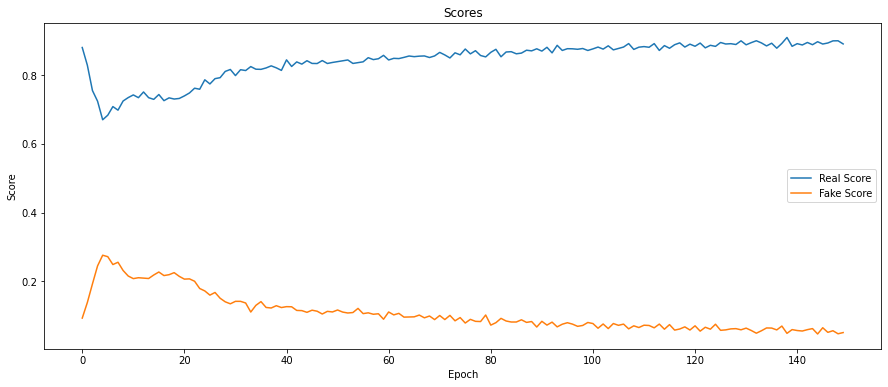

In [15]:
plt.figure(figsize=(15, 6))
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.legend(['Real Score', 'Fake Score'])
plt.title('Scores');

На графике видно, что в процессе обучения дискриминатор все меньше и меньше выдавал вероятность, что изображение ненастоящее. Т.е. к концу обучения генератор успешно обманывал дискриминатор сгенерированными изображениями.

Выведим графики лоссов:

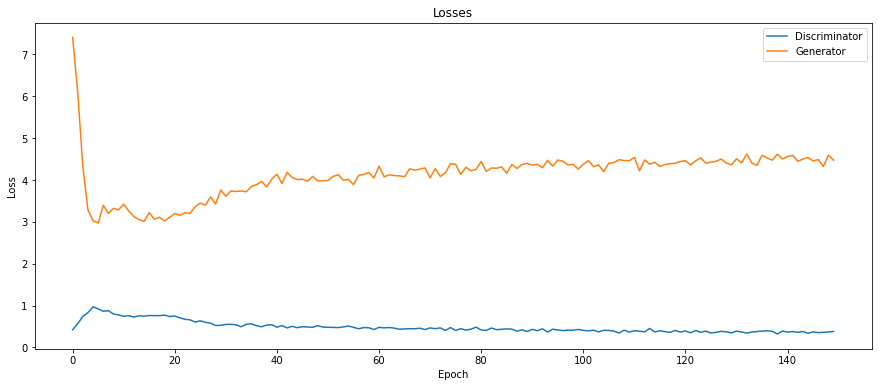

In [16]:
plt.figure(figsize=(15, 6))
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

Видно, что значения лосса генератора достаточно большие. Но большие показания лосса генератора свидетельствуют о том, что он генерирует изображения лиц, а не рандомный шум. Если бы лосс генератора был бы маленьким, то дискриминатор бы оценивал зашумленные изображения, как настоящие во всех случаях и тогда генератор бы не смог обучиться. Качество генеративных сетей лучше оценивать по сгенерированным изображениям, нежели по метрикам:

In [17]:
import os
import numpy as np
import matplotlib.pyplot as plt
import imageio

filenames = []

entries = os.scandir('generated/')
for entry in os.listdir('generated/'):
    if os.path.isfile(os.path.join('generated/', entry)):
        if entry.endswith(".png"):
            filenames.append('generated/' + entry)
        
with imageio.get_writer('generated/movie.gif', mode='I') as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)

![SegmentLocal](assets/movie.gif "segment")

Изображения генерируются и похожи на изображения лиц людей, хотя и есть некоторые искажения.

Посмотрим как выглядит изображение при epoch = 150:

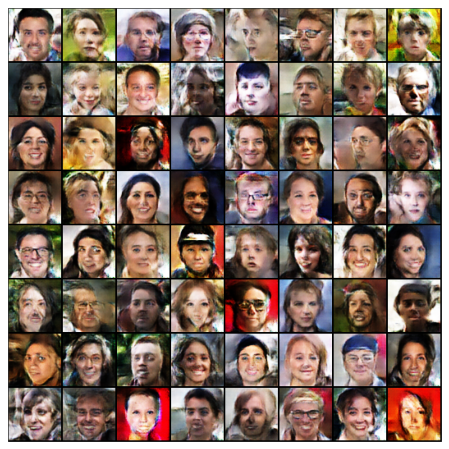

In [104]:
generated_img = imageio.imread('./generated/generated-images-0150.png')

fig, ax = plt.subplots(figsize=(8, 8))
ax.set_xticks([]); ax.set_yticks([])
ax.imshow(generated_img)

## 3. Генерация изображений

Выполним сэмплинг с помощью нашего генератора и посмотрим какие изображения у нас получатся:

In [116]:
n_images = 24
model["generator"].eval()
fixed_latent = torch.randn(n_images, latent_size, latent_shape, latent_shape, device=device)
fake_images = model["generator"](fixed_latent)

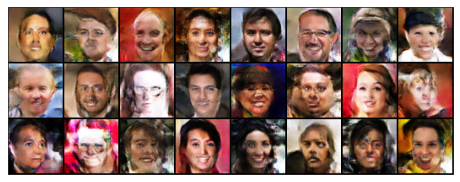

In [117]:
show_images(fake_images.detach().cpu())

Некоторые изображения похожи на лица людей, но немного искаженные. А некоторые выглядят как будто подверглись какой-то обработке.

In [18]:
EPOCH = 150
PATH = "./models/model_23072020.pt"

torch.save({
            'epoch': EPOCH,
            'discriminator': discriminator.state_dict(),
            'generator': generator.state_dict(),
            'optim_dis': optim_dis.state_dict(),
            'optim_gen': optim_gen.state_dict(),
            'loss_d': losses_d,
            'loss_g': losses_g,
            'real_score': real_scores,
            'fake_score': fake_scores,
            }, PATH)

checkpoint = torch.load(PATH)